## Import dependencies

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
from scipy.fftpack import dct
import numpy as np
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from transformers import DistilBertTokenizer, TFDistilBertModel

## Dataloader

In [10]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/train_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/train_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/test_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=False,
                                                   batch_size = 64)

Found 36411 images belonging to 7 classes.
Found 15601 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [11]:
print(train_dataset.class_indices)
print(validation_dataset.class_indices)
print(test_dataset.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Metrics

In [12]:
def f1_score(y_true, y_pred):
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

## Model

#### CBAM

In [13]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    ## Shared layers
    l1 = K.layers.Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = K.layers.Dense(channel, use_bias=False)
    ## Global Average Pooling
    x1 = K.layers.GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    ## Global Max Pooling
    x2 = K.layers.GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = K.layers.Activation("sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    ## Concatenat both the features
    feats = K.layers.Concatenate()([x1, x2])
    ## Conv layer
    feats = K.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

#### Deep Learner

In [14]:
input_layer = K.Input(shape=(160,160,3))
deep_learner = K.applications.NASNetMobile(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in deep_learner.layers:
    layer.trainable = True
for i, layer in enumerate(deep_learner.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_3 - True
1 stem_conv1 - True
2 stem_bn1 - True
3 activation_188 - True
4 reduction_conv_1_stem_1 - True
5 reduction_bn_1_stem_1 - True
6 activation_189 - True
7 activation_191 - True
8 separable_conv_1_pad_reduction_left1_stem_1 - True
9 separable_conv_1_pad_reduction_right1_stem_1 - True
10 separable_conv_1_reduction_left1_stem_1 - True
11 separable_conv_1_reduction_right1_stem_1 - True
12 separable_conv_1_bn_reduction_left1_stem_1 - True
13 separable_conv_1_bn_reduction_right1_stem_1 - True
14 activation_190 - True
15 activation_192 - True
16 separable_conv_2_reduction_left1_stem_1 - True
17 separable_conv_2_reduction_right1_stem_1 - True
18 activation_193 - True
19 separable_conv_2_bn_reduction_left1_stem_1 - True
20 separable_conv_2_bn_reduction_right1_stem_1 - True
21 separable_conv_1_pad_reduction_right2_stem_1 - True
22 activation_195 - True
23 reduction_add_1_stem_1 - True
24 separable_conv_1_reduction_right2_stem_1 - True
25 separable_conv_1_pad_reduction_right3_stem_1

#### Model

In [15]:
input_img = K.layers.Input(shape=(160,160,3)) 
feat_img = deep_learner(input_img)
flat = K.layers.GlobalAveragePooling2D()(feat_img)
output = K.layers.Dense(7, activation='softmax')(flat)

model = K.Model(inputs=input_img, outputs=output)
optimizer = K.optimizers.Adam(lr=0.01)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 5, 5, 1056)        4269716   
                                                                 
 global_average_pooling2d_1   (None, 1056)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 7)                 7399      
                                                                 
Total params: 4,277,115
Trainable params: 4,240,377
Non-trainable params: 36,738
_________________________________________________________________


## Training

In [16]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='NASNetMobile.h5',
    monitor='val_f1_score',
    save_best_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/50
569/569 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.8062 - precision: 0.8583 - recall: 0.7601 - auc: 0.9763 - f1_score: 0.8001
Epoch 1: val_f1_score improved from -inf to 0.26534, saving model to NASNetMobile.h5
569/569 [==============================] - 408s 465ms/step - loss: 0.5241 - accuracy: 0.8062 - precision: 0.8583 - recall: 0.7601 - auc: 0.9763 - f1_score: 0.8001 - val_loss: 9.0262 - val_accuracy: 0.2652 - val_precision: 0.2672 - val_recall: 0.2636 - val_auc: 0.5788 - val_f1_score: 0.2653
Epoch 2/50
569/569 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.9055 - precision: 0.9215 - recall: 0.8902 - auc: 0.9929 - f1_score: 0.9055
Epoch 2: val_f1_score did not improve from 0.26534
569/569 [==============================] - 232s 407ms/step - loss: 0.2665 - accuracy: 0.9055 - precision: 0.9215 - recall: 0.8902 - auc: 0.9929 - f1_score: 0.9055 - val_loss: 61.6061 - val_accuracy: 0.1892 - val_precision: 0.1892 - val_recal

#### Training plots

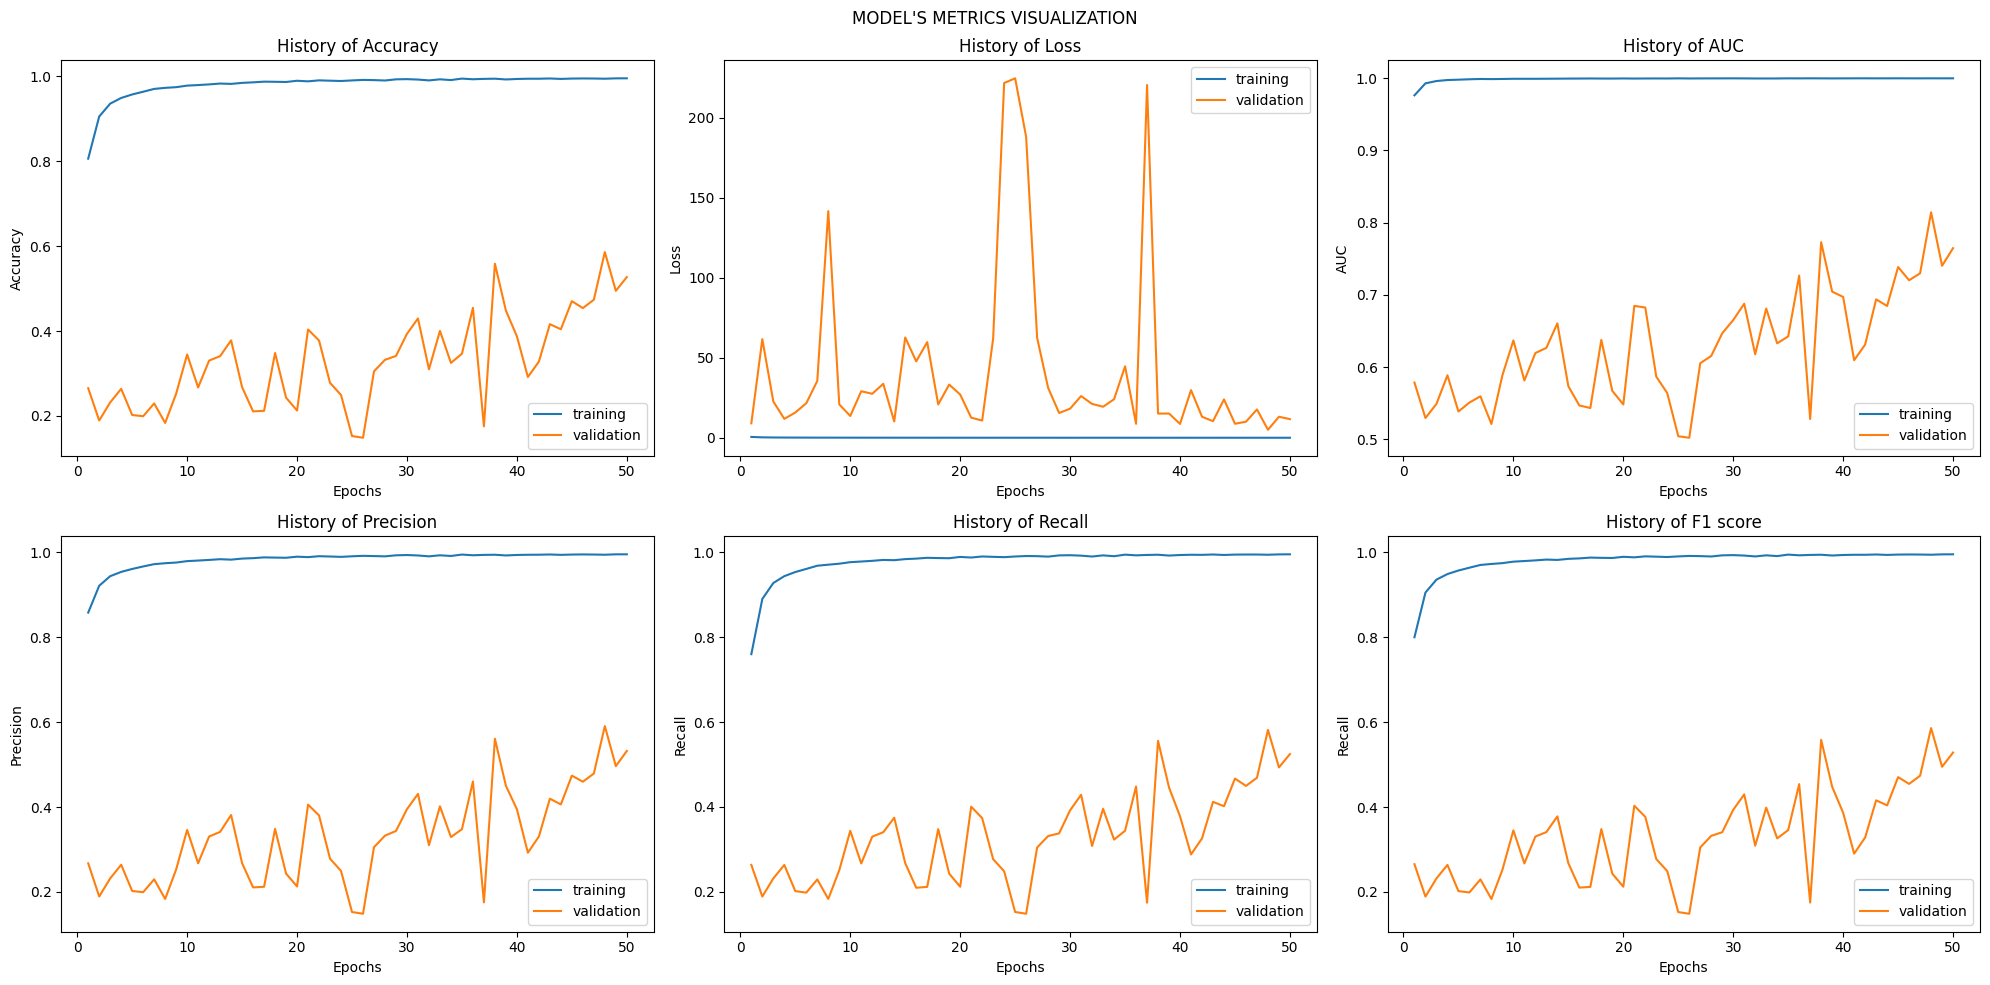

In [17]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    axes[0, 0].plot(range(1, len(acc) + 1), acc)
    axes[0, 0].plot(range(1, len(val_acc) + 1), val_acc)
    axes[0, 0].set_title('History of Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(['training', 'validation'])

    axes[0, 1].plot(range(1, len(loss) + 1), loss)
    axes[0, 1].plot(range(1, len(val_loss) + 1), val_loss)
    axes[0, 1].set_title('History of Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(['training', 'validation'])

    axes[0, 2].plot(range(1, len(auc) + 1), auc)
    axes[0, 2].plot(range(1, len(val_auc) + 1), val_auc)
    axes[0, 2].set_title('History of AUC')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('AUC')
    axes[0, 2].legend(['training', 'validation'])

    axes[1, 0].plot(range(1, len(precision) + 1), precision)
    axes[1, 0].plot(range(1, len(val_precision) + 1), val_precision)
    axes[1, 0].set_title('History of Precision')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend(['training', 'validation'])

    axes[1, 1].plot(range(1, len(recall) + 1), recall)
    axes[1, 1].plot(range(1, len(val_recall) + 1), val_recall)
    axes[1, 1].set_title('History of Recall')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend(['training', 'validation'])

    axes[1, 2].plot(range(1, len(f1_score) + 1), f1_score)
    axes[1, 2].plot(range(1, len(val_f1_score) + 1), val_f1_score)
    axes[1, 2].set_title('History of F1 score')
    axes[1, 2].set_xlabel('Epochs')
    axes[1, 2].set_ylabel('Recall')  # Corrected from 'Recall' to 'F1 score'
    axes[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

# Call the function with your history data
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['recall'], history.history['val_recall'],
               history.history['f1_score'], history.history['val_f1_score'])

## Testing

In [18]:
model = K.models.load_model("/kaggle/working/NASNetMobile.h5", custom_objects={"f1_score": f1_score})

# Evaluate the model
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Accuracy", accuracy)
print("Loss", loss)
print("Precision", precision)
print("Recall", recall)
print("AUC", auc)
print("F1-score", f1_score)

18/18 [==============================] - 8s 435ms/step - loss: 3.6032 - accuracy: 0.6908 - precision: 0.6927 - recall: 0.6908 - auc: 0.8708 - f1_score: 0.6931
Accuracy 0.6908431649208069
Loss 3.60324764251709
Precision 0.692727267742157
Recall 0.6908431649208069
AUC 0.8707754611968994
F1-score 0.6931015849113464


/tmp/ipykernel_28/493592024.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


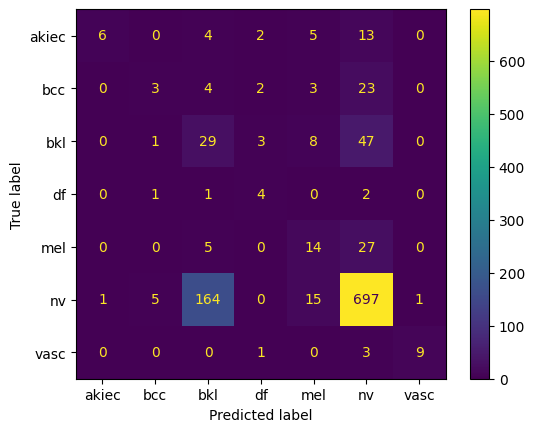

Classification Report
              precision    recall  f1-score   support

       akiec       0.86      0.20      0.32        30
         bcc       0.30      0.09      0.13        35
         bkl       0.14      0.33      0.20        88
          df       0.33      0.50      0.40         8
         mel       0.31      0.30      0.31        46
          nv       0.86      0.79      0.82       883
        vasc       0.90      0.69      0.78        13

    accuracy                           0.69      1103
   macro avg       0.53      0.41      0.42      1103
weighted avg       0.76      0.69      0.71      1103



In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))